In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.15.0


## Prepare Dataset

In [5]:
# train_dataset_path = './dataset/dataset-raw-asli/train_preprocess.tsv'
# valid_dataset_path = './dataset/dataset-raw-asli/valid_preprocess.tsv'

train_df_path = '../dataset/indo-nlu-socialabs-penelitian-merged-new-clean-tanpa-testing.csv'


In [6]:
# train_df = pd.read_csv(train_dataset_path, sep='\t', header=None)
# valid_df = pd.read_csv(valid_dataset_path, sep='\t', header=None)

# train_df.columns = ['text', 'label']
# valid_df.columns = ['text', 'label']

train_df = pd.read_csv(train_df_path, sep=',', header=None, usecols=[1,2], skiprows=1)

# train_df = pd.read_csv(train_dataset_path, sep=',', header=None, usecols=[1,2], skiprows=1)
# valid_df = pd.read_csv(valid_dataset_path, sep=',', header=None, usecols=[1,2], skiprows=1)

train_df.columns = ['label', 'tweet_tokens_no_stemming']
# valid_df.columns = ['label', 'tweet_tokens_no_stemming']

In [7]:
train_df.head(10)

,label,tweet_tokens_no_stemming
0,positive,"['warung', 'milik', 'usaha', 'pabrik', 'puluh'..."
1,neutral,"['mohon', 'ulama', 'lurus', 'mbri', 'hujah', '..."
2,positive,"['lokasi', 'strategis', 'jalan', 'sumatera', '..."
3,positive,"['betapa', 'bahagia', 'sat', 'unboxing', 'pake..."
4,negative,"['duh', 'mahasiswa', 'jangan_sombong', 'kasih'..."
5,positive,"['makan', 'agam', 'harga', 'makan', 'fod', 'st..."
6,negative,"['pakai', 'kartu', 'kredit', 'baca', 'tidak_un..."
7,positive,"['unik', 'bagus', 'foto-foto', 'makan', 'enak'..."
8,positive,"['keluarga', 'nikmat', 'alam', 'kuliner', 'sen..."
9,positive,['syukur']


In [8]:
train_df.head(10)

,label,tweet_tokens_no_stemming
0,positive,"['warung', 'milik', 'usaha', 'pabrik', 'puluh'..."
1,neutral,"['mohon', 'ulama', 'lurus', 'mbri', 'hujah', '..."
2,positive,"['lokasi', 'strategis', 'jalan', 'sumatera', '..."
3,positive,"['betapa', 'bahagia', 'sat', 'unboxing', 'pake..."
4,negative,"['duh', 'mahasiswa', 'jangan_sombong', 'kasih'..."
5,positive,"['makan', 'agam', 'harga', 'makan', 'fod', 'st..."
6,negative,"['pakai', 'kartu', 'kredit', 'baca', 'tidak_un..."
7,positive,"['unik', 'bagus', 'foto-foto', 'makan', 'enak'..."
8,positive,"['keluarga', 'nikmat', 'alam', 'kuliner', 'sen..."
9,positive,['syukur']


In [9]:
def get_label_idx(label):
    if label == 'positive':
        return 2
    if label == 'negative':
        return 1
    if label == 'neutral':
        return 0
train_df['label'] = train_df['label'].apply(get_label_idx)
# valid_df['label'] = valid_df['label'].apply(get_label_idx)


In [10]:
train_df

,label,tweet_tokens_no_stemming
0,2,"['warung', 'milik', 'usaha', 'pabrik', 'puluh'..."
1,0,"['mohon', 'ulama', 'lurus', 'mbri', 'hujah', '..."
2,2,"['lokasi', 'strategis', 'jalan', 'sumatera', '..."
3,2,"['betapa', 'bahagia', 'sat', 'unboxing', 'pake..."
4,1,"['duh', 'mahasiswa', 'jangan_sombong', 'kasih'..."
...,...,...
42995,2,"['beli', 'revitalift', 'laser', 'renewing', 'a..."
42996,2,"['kali', 'coba', 'serum', 'minyak', 'malam', '..."
42997,2,"['masuk', 'tahun-tahun', 'kuna', 'awat', 'faci..."
42998,2,"['hidup', 'sesuai', 'bad', 'haritulah', 'kalim..."


In [11]:
jumlah_positives = (train_df['label'] == 2).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (train_df['label'] == 1).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 21482
Jumlah review negatif: 19255


In [12]:
# join list of token as single document string
import ast

def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])
train_df["preprocessed"] = train_df["tweet_tokens_no_stemming"].apply(join_text_list)
# valid_df["preprocessed"] = valid_df["tweet_tokens_no_stemming"].apply(join_text_list)

train_df["preprocessed"].head()

0    warung milik usaha pabrik puluh tahun-tahun ke...
1    mohon ulama lurus mbri hujah partai apa-apa di...
2    lokasi strategis jalan sumatera bandung nyaman...
3    betapa bahagia sat unboxing paket barang bagus...
4    duh mahasiswa jangan_sombong kasih kartu kunin...
Name: preprocessed, dtype: object

In [13]:
# Filter DataFrame untuk label 1 dan 2
df_train_filtered = train_df[train_df['label'].isin([1, 2])]
# df_valid_filtered = valid_df[valid_df['label'].isin([1, 2])]

# Perbarui label sehingga label 1 menjadi 0 dan label 2 menjadi 1
df_train_filtered.loc[:, 'label'] = df_train_filtered['label'].map({1: 0, 2: 1})
# df_valid_filtered.loc[:, 'label'] = df_valid_filtered['label'].map({1: 0, 2: 1})


# Split dataset menjadi fitur (X) dan label (y)
X_train = df_train_filtered['preprocessed']
y_train = df_train_filtered['label']

# X_valid = df_valid_filtered['preprocessed']
# y_valid = df_valid_filtered['label']

In [14]:
## hitung jumlah positive dan negative
jumlah_positives = (y_train == 1).sum()
print(f'Jumlah review positif: {jumlah_positives}')

jumlah_negatives = (y_train == 0).sum()
print(f'Jumlah review negatif: {jumlah_negatives}')

# jumlah_positives = (y_valid == 1).sum()
# print(f'Jumlah review positif: {jumlah_positives}')

# jumlah_negatives = (y_valid == 0).sum()
# print(f'Jumlah review negatif: {jumlah_negatives}')

Jumlah review positif: 21482
Jumlah review negatif: 19255


In [15]:
##split dataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1,stratify=y_train, random_state=42)

In [16]:
# average length X_valid sentences
avg_len = np.mean(X_train.apply(lambda x: len(x.split())))
print(f'Average length of sentences: {avg_len}')

Average length of sentences: 16.22128576494013


## Generate Padded Sequence

In [17]:
# Parameters

vocab_size = 60000 #ukuran kosakata yang akan digunakan
max_length = 50 #panjang maksimal dari sebuah kalimat
embedding_dim = 8 #dimensi vektor embedding yang akan digunakan
trunc_type='post' #jika panjang kalimat melebihi max_length, potong bagian belakang kalimat
oov_tok = "<OOV>" #OOV (Out Of Vocabulary) token, jika suatu kata tidak ditemukan dalam kosakata

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re

# Preprocess texts to retain underscore and tokenize specific punctuations
def preprocess_text(text):
    to_tokenize = '.,:;!?'
    return re.sub(r'([' + re.escape(to_tokenize) + '])', r' \1 ', text)

# Apply preprocessing
X_train = [preprocess_text(text) for text in X_train]
X_valid = [preprocess_text(text) for text in X_valid]

# Tokenisasi
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok, filters='!"#$%&()*+-/:;<=>@[\\]^`{|}~\t\n')

# Gabungkan semua teks untuk membuat kamus indeks kata
all_texts = list(X_train) + list(X_valid)

# Membuat kamus indeks kata
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
word_index


# Konversi kalimat menjadi urutan kata
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type, padding="post")

valid_sequences = tokenizer.texts_to_sequences(X_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type, padding="post")




In [17]:
# import pickle

# Simpan tokenizer ke dalam file
# with open('tokenizer-2classes-no-stemming.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [19]:
print(train_padded[0])

[  113  2760  1312  3536  5567 20546  1279  6278  5568  4778  1190    50
    32  2760   757    32 20547  1462 11973  1135   501     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


## Word Embedding

In [30]:
from gensim.models import Word2Vec

# Gabungkan data pelatihan dan validasi
sentences = [sentence.split() for sentence in X_train] + [sentence.split() for sentence in X_valid]

# Latih model Word2Vec
w2v_model = Word2Vec(sentences, vector_size=8, window=5, min_count=5, workers=4)

In [38]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 8))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        

In [39]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.73317373, -1.59424078,  4.69000626, ..., -4.85450697,
         3.46414876,  3.71313882],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [40]:
embedding_matrix.shape

(60000, 8)

In [41]:
# Mencari kata berdasarkan vektor tertentu
def find_word_by_vector(embedding_matrix, vector):
    for word, index in word_index.items():
        if np.array_equal(embedding_matrix[index], vector):
            return word, embedding_matrix[index]
    return None

# Contoh: Mencari kata untuk vektor embedding_matrix[3]
word = find_word_by_vector(embedding_matrix, embedding_matrix[345])
print(word)

('teh', array([ 2.14407849, -0.01074575,  2.81207395, -0.17691165, -0.56396526,
       -0.40823925,  4.45030737,  2.3751893 ]))


## Build and Compile Model

In [42]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Concatenate

# def create_model_with_multiple_kernels(vocab_size, embedding_matrix, max_length):
#     # Input layer
#     inputs = Input(shape=(max_length,))
    
#     # Embedding layer
#     x = Embedding(input_dim=vocab_size, output_dim=8, 
#                   embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
#                   trainable=False)(inputs)
    
#     # Define branches with different kernel sizes
#     kernel_sizes = [3, 5, 7, 9]
#     branches = []
    
#     for kernel_size in kernel_sizes:
#         branch = Conv1D(filters=128, kernel_size=kernel_size, activation='relu', padding='same')(x)
#         branch = MaxPooling1D(pool_size=2)(branch)
#         branches.append(branch)
    
#     # Merge branches
#     merged = Concatenate()(branches)
    
#     # Bidirectional LSTM layer
#     x = LSTM(128)(merged)
    
#     # Dense layers
#     x = Dense(16, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     outputs = Dense(1, activation='sigmoid')(x)
    
#     # Create and compile model
#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

# # Example usage
# vocab_size = 60000
# embedding_matrix = embedding_matrix
# max_length = 50
# model = create_model_with_multiple_kernels(vocab_size, embedding_matrix, max_length)

# model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 50)        │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ embedding_6         │ (None, 50, 8)     │ 480,000 │ input_layer_6[0][0]  │
│ (Embedding)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 50, 128)   │   3,200 │ embedding_6[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 50, 128)   │   5,248 │ embedding_6[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 50, 128)   │   7,296 │ embedding_6[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 50, 128)   │   9,344 │ embedding_6[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling1d_4     │ (None, 25, 128)   │       0 │ conv1d_4[0][0]       │
│ (MaxPooling1D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling1d_5     │ (None, 25, 128)   │       0 │ conv1d_5[0][0]       │
│ (MaxPooling1D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling1d_6     │ (None, 25, 128)   │       0 │ conv1d_6[0][0]       │
│ (MaxPooling1D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling1d_7     │ (None, 25, 128)   │       0 │ conv1d_7[0][0]       │
│ (MaxPooling1D)      │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate_1       │ (None, 25, 512)   │       0 │ max_pooling1d_4[0][… │
│ (Concatenate)       │                   │         │ max_pooling1d_5[0][… │
│                     │                   │         │ max_pooling1d_6[0][… │
│                     │                   │         │ max_pooling1d_7[0][… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │ 328,192 │ concatenate_1[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │   2,064 │ lstm_1[0][0]         │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │       0 │ dense_2[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      17 │ dropout_1[0][0]      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 835,361 (3.19 MB)

 Trainable params: 835,361 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# convert to bi-lstm model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
              input_shape=(max_length,), trainable=False),
    tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(128),  # Menambahkan LSTM layer
    tf.keras.layers.Dropout(0.5),   
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 50, 8)             │    480,000 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_9 (Conv1D)               │ (None, 50, 128)           │      5,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 128)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 25, 128)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)               │    131,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_4 (Dropout)             │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 200)               │     25,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 100)               │     20,100 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 50)                │      5,050 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 30)                │      1,530 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 1)                 │         31 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 669,343 (2.55 MB)

 Trainable params: 669,343 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# Looping untuk mendapatkan bobot dari setiap layer
for layer in model.layers:
    # Mengecek apakah layer memiliki bobot
    if layer.weights:
        print("Layer Name:", layer.name)
        # Mendapatkan bobot dan bias dari layer
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            print("Weights Shape (Tensor {}):".format(i), w.shape)
            print("Weights (Tensor {}):".format(i))
            print(w)


Layer Name: embedding_1
Weights Shape (Tensor 0): (60000, 8)
Weights (Tensor 0):
[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [-4.70537   -1.4904379  4.5354424 ... -3.3459175  3.0429876 -1.5427088]
 ...
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]]
Layer Name: conv1d_1
Weights Shape (Tensor 0): (5, 8, 128)
Weights (Tensor 0):
[[[ 0.08292843 -0.08553228  0.06398341 ... -0.09353916  0.07014036
    0.09358336]
  [ 0.00579786  0.0523396   0.0055796  ... -0.04490695  0.06817706
    0.02915289]
  [-0.07884707  0.0692987  -0.01820277 ... -0.00684486 -0.08298743
   -0.02562064]
  ...
  [-0.04288781  0.03635649  0.03351864 ...  0.04675382 -0.01067998
   -0.0265165 ]
  [ 0.06583183  0.06285606  0.06738335 ... -0.04946661 -0.

## Train Model

In [52]:
num_epochs = 20
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(train_padded, y_train, batch_size=128, epochs=num_epochs, validation_data=(valid_padded, y_valid), callbacks=[lr_schedule, early_stopping])


Epoch 1/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 44s 130ms/step - accuracy: 0.6529 - loss: 0.6073 - val_accuracy: 0.7941 - val_loss: 0.4568 - learning_rate: 1.0000e-04
Epoch 2/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 37s 129ms/step - accuracy: 0.7911 - loss: 0.4616 - val_accuracy: 0.8027 - val_loss: 0.4399 - learning_rate: 1.1220e-04
Epoch 3/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - accuracy: 0.7983 - loss: 0.4437 - val_accuracy: 0.8002 - val_loss: 0.4415 - learning_rate: 1.2589e-04
Epoch 4/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 36s 124ms/step - accuracy: 0.8085 - loss: 0.4310 - val_accuracy: 0.7963 - val_loss: 0.4323 - learning_rate: 1.4125e-04
Epoch 5/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - accuracy: 0.8055 - loss: 0.4305 - val_accuracy: 0.8083 - val_loss: 0.4241 - learning_rate: 1.5849e-04
Epoch 6/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 37s 127ms/step - accuracy: 0.8158 - loss: 0.4177 - val_accuracy: 0.8120 - val_loss: 0.4195 - learning_rate: 1.7783e-04
Epoch 7/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 33s 11

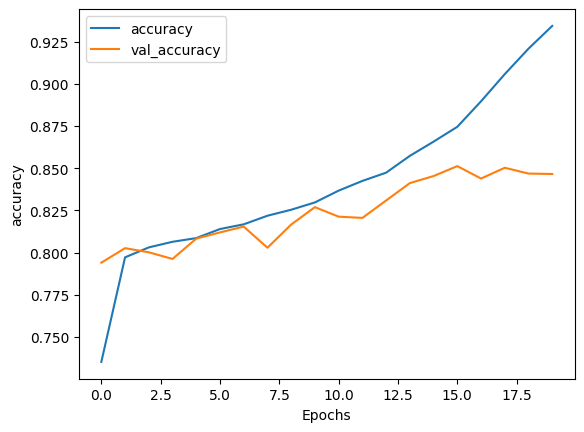

In [53]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

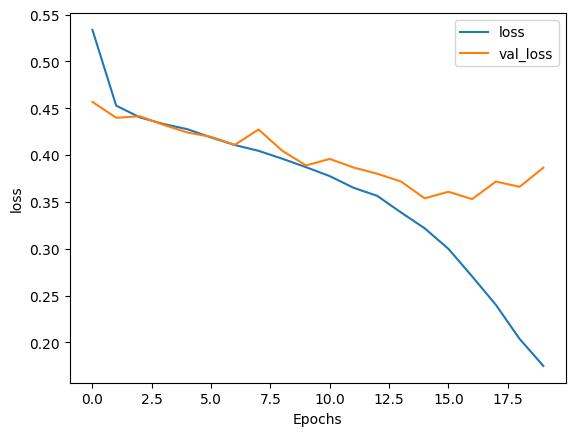

In [54]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [55]:
# Asumsi model dan tokenizer sudah didefinisikan
def predict_sentiment(model, tokenizer, text):
    # Tokenisasi teks
    sample_seq = tokenizer.texts_to_sequences([text])
    sample_padded = pad_sequences(sample_seq, maxlen=max_length, truncating=trunc_type, padding="post")
    
    # Prediksi sentimen menggunakan model
    prediction = model.predict(sample_padded)
    print(prediction)
    # Mengembalikan label sentimen berdasarkan output model
    if prediction >= 0.5:
        return "Positif"
    else:
        return "Negatif"

# Kalimat contoh untuk pengujian
test_sentences = [
    "Pada awalnya saya ragu dengan kemampuan perusahaan ini, namun setelah melihat kinerja mereka selama beberapa bulan terakhir, saya sangat puas dengan hasil yang mereka capai.",
    "Film ini memulai dengan sangat membosankan dan lambat, tetapi akhir ceritanya sangat mengharukan dan membuat saya terkesan.",
    "Meskipun layanan pelanggan mereka sangat lambat dan kurang responsif, kualitas produk yang mereka tawarkan sangatlah bagus.",
    "Restoran ini memiliki makanan yang lezat, tetapi pelayanannya sangat buruk dan membuat pengalaman makan saya tidak menyenangkan.",
    "Saya mengalami banyak masalah dengan perangkat ini di awal, namun setelah pembaruan terbaru, kinerjanya menjadi jauh lebih baik.",
    "Aplikasi ini sering mengalami crash pada versi awal, tetapi sekarang setelah beberapa pembaruan, aplikasinya sangat stabil dan berguna.",
    "Hotel ini memiliki pemandangan yang luar biasa dan staf yang ramah, meskipun kamarnya cukup kotor pada saat saya tiba.",
    "Buku ini dimulai dengan alur yang sangat lambat, namun karakter dan ceritanya berkembang dengan sangat baik menjelang akhir.",
    "Konser ini awalnya terasa membosankan, tetapi penampilan penutupnya sangat spektakuler dan membuat semuanya terbayar.",
    "Saya awalnya kecewa dengan kualitas pakaian ini, tetapi setelah beberapa kali dicuci, kualitas bahannya ternyata sangat tahan lama.",
    "Saya tidak masalah sama sekali gaji dipotong tiap bulan untuk BPJS Kesehatan. Semisal jarang pakai pun, anggap saja sedekah dan membantu sesama.  Tapi untuk TAPERA ini, jelas saya tidak ikhlas. Subsidi silang buat yang tidak mampu? Ah tidak juga rasanya.  Kebijakan aneh.",
    "Kebijakan pemerintah tentang kenaikan harga BBM sangat memberatkan masyarakat kecil.",
    "Reformasi pajak yang diusulkan akan sangat membantu meningkatkan perekonomian negara.",
    "Keputusan untuk memperpanjang masa jabatan presiden sangat kontroversial dan memicu banyak protes.",
    "Program bantuan sosial yang baru diluncurkan sangat membantu masyarakat miskin.",
    "Pemilihan umum kali ini sangat penting untuk masa depan negara kita.",
    "Banyak yang kecewa dengan hasil debat politik semalam, banyak janji yang tidak realistis.",
    "Tindakan korupsi yang dilakukan oleh pejabat tinggi harus ditindak tegas.",
    "Perubahan undang-undang ini sangat penting untuk melindungi hak-hak pekerja.",
    "Diskusi tentang kebijakan luar negeri semakin memanas, banyak pihak yang berbeda pendapat.",
    "Partai oposisi mengkritik keras kebijakan ekonomi pemerintah yang dianggap tidak efektif.",
    "Rencana pembangunan infrastruktur baru di wilayah timur sangat disambut baik oleh masyarakat."
]
   
# Memprediksi sentimen untuk setiap kalimat dan menyimpan hasil ke DataFrame
results = []

for sentence in test_sentences:
    predicted_label = predict_sentiment(model, tokenizer, sentence)
    results.append({"Teks": sentence, "Label Sentimen": predicted_label})

# Membuat DataFrame
df = pd.DataFrame(results)

# Menyimpan DataFrame ke file CSV
# df.to_csv('prediksi_sentimen-cnn-bilstm.csv', index=False)

df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
[[0.5992192]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.6678817]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.43014345]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.17134942]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[0.7573164]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.7842177]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.41385958]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[0.40289593]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.82701063]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.6632987]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.06186219]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.77157104]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.05621158]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.05374221]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.78386754]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[0.55972064]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[[0.08196712]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.03388845]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[0.77500135

,Teks,Label Sentimen
0,Pada awalnya saya ragu dengan kemampuan perusa...,Positif
1,Film ini memulai dengan sangat membosankan dan...,Positif
2,Meskipun layanan pelanggan mereka sangat lamba...,Negatif
3,"Restoran ini memiliki makanan yang lezat, teta...",Negatif
4,Saya mengalami banyak masalah dengan perangkat...,Positif
5,Aplikasi ini sering mengalami crash pada versi...,Positif
6,Hotel ini memiliki pemandangan yang luar biasa...,Negatif
7,Buku ini dimulai dengan alur yang sangat lamba...,Negatif
8,"Konser ini awalnya terasa membosankan, tetapi ...",Positif
9,Saya awalnya kecewa dengan kualitas pakaian in...,Positif


In [56]:
def predict_sentiment(model, tokenizer, text):
    # Tokenisasi teks
    sample_seq = tokenizer.texts_to_sequences([text])
    sample_padded = pad_sequences(sample_seq, maxlen=max_length, truncating=trunc_type, padding="post")
    
    # Prediksi sentimen menggunakan model
    prediction = model.predict(sample_padded)
    print(prediction)
    # Mengembalikan label sentimen berdasarkan output model
    if prediction >= 0.5:
        return "Positif"
    else:
        return "Negatif"

# Menggunakan fungsi untuk memprediksi sentimen dari contoh kalimat
sample_text = "pakai memoisturizer ini jelek"
predicted_label = predict_sentiment(model, tokenizer, sample_text)
print("Label Sentimen:", predicted_label)
   


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
[[0.04090882]]
Label Sentimen: Negatif


In [57]:
from sklearn.metrics import classification_report

# Melakukan prediksi pada data uji
y_pred = model.predict(valid_padded)
y_pred_classes = (y_pred >= 0.5).astype(int)

# Mencetak classification report
print(classification_report(y_valid, y_pred_classes))

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1926
           1       0.89      0.80      0.84      2148

    accuracy                           0.84      4074
   macro avg       0.85      0.85      0.84      4074
weighted avg       0.85      0.84      0.84      4074



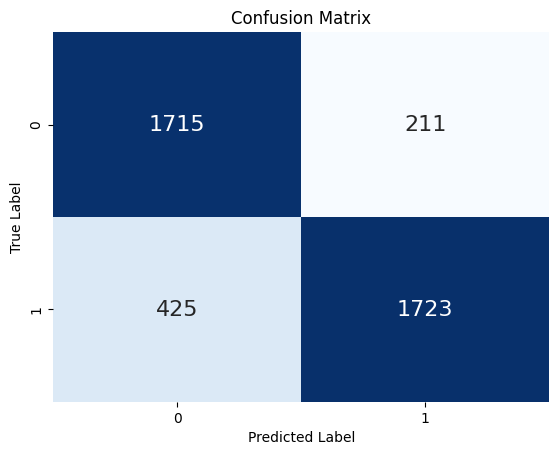

In [58]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Membuat confusion matrix
cm = confusion_matrix(y_valid, y_pred_classes)

# Membuat heatmap dari confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [175]:
print(cm)

[[1417  222]
 [ 190 1527]]


In [176]:
# from sklearn.model_selection import KFold
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # Hyperparameters
# vocab_size = 23000
# oov_tok = "<OOV>"
# max_length = 100
# trunc_type = 'post'
# embedding_dim = 8
# num_folds = 5

# # Prepare the tokenizer and word index
# all_texts = list(X_train) + list(X_valid)
# tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# tokenizer.fit_on_texts(all_texts)
# word_index = tokenizer.word_index

# # Convert the sentences into sequences
# train_sequences = tokenizer.texts_to_sequences(X_train)
# train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

# valid_sequences = tokenizer.texts_to_sequences(X_valid)
# valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type)

# # Combine training and validation data for K-Fold
# X = np.concatenate((train_padded, valid_padded), axis=0)
# y = np.concatenate((y_train, y_valid), axis=0)

# # K-Fold Cross Validation
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# fold_no = 1
# for train_index, valid_index in kf.split(X):
#     print(f'Training fold {fold_no} ...')

#     # Split data
#     X_train_fold, X_valid_fold = X[train_index], X[valid_index]
#     y_train_fold, y_valid_fold = y[train_index], y[valid_index]

#     # Build the model
#     model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(max_length,)),
#         tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same'),
#         tf.keras.layers.MaxPooling1D(pool_size=2),
#         tf.keras.layers.LSTM(100),
#         tf.keras.layers.Dense(16, activation='relu'),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])

#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#     # Train the model
#     history = model.fit(X_train_fold, y_train_fold, epochs=4, validation_data=(X_valid_fold, y_valid_fold))

#     print(f'Fold {fold_no} completed')

#     fold_no += 1

# # Evaluate the final model on all data (optional)
# final_loss, final_accuracy = model.evaluate(X, y)
# print(f'Final loss: {final_loss}, Final accuracy: {final_accuracy}')


In [31]:
#save model
# model.save('./model/model-cnn-bilstm.h5')

ValueError: Unable to synchronously create dataset (name already exists)